In [1]:
#%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment
#%pip install -q plotly==5.4.0

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
from os import path

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt
from skimage.io import imread
import pandas as pd
import yaml
from skimage import filters

# from cucim.skimage.morphology import binary_erosion, disk
from basicpy import BaSiC
from basicpy.metrics import autotune_cost, entropy, fourier_L0_norm

In [4]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = "./"

nuc_channel_idx = 2
cyto_channel_idx = 0

In [5]:
import jax

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_default_device", jax.devices()[2])

In [6]:
flatfield_true = np.load(path.join(file_path, f"flatfield_true.npy"))

In [7]:
weights = imread(path.join(file_path, "weights.tif"))

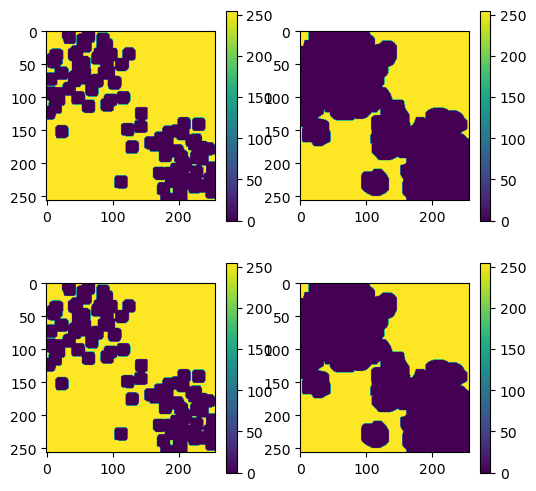

In [8]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()

In [9]:
darkfield_true = np.load(path.join(file_path, f"darkfield_true.npy"))
baseline_true = np.load(path.join(file_path, f"baseline_true.npy"))

In [10]:
images_distorted_wo_darkfield = imread(path.join(file_path, "wo_darkfield2.tif"))
images_distorted_w_darkfield = imread(path.join(file_path, "w_darkfield2.tif"))

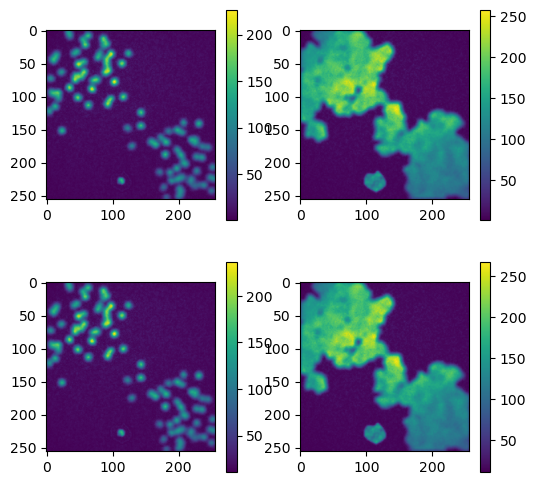

In [11]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(images_distorted_wo_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(images_distorted_wo_darkfield[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(images_distorted_w_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(images_distorted_w_darkfield[cyto_channel_idx, 100])
plt.colorbar()

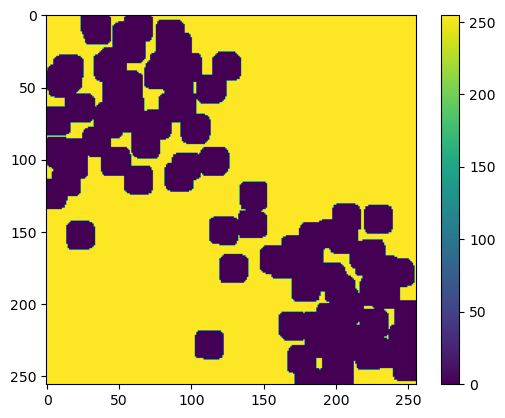

In [12]:
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()

In [13]:
def add_noise(im):
    if im.ndim > 2:
        return np.array(
            [
                filters.gaussian(np.random.poisson(_im), sigma=1, preserve_range=True)
                for _im in im
            ]
        )
    else:
        return filters.gaussian(np.random.poisson(im), sigma=1, preserve_range=True)

In [14]:
images_distorted_wo_darkfield_with_noise = []
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    im = images_distorted_wo_darkfield[channel_index]
    im = add_noise(im)
    images_distorted_wo_darkfield_with_noise.append(im)
np.save(
    "images_distorted_wo_darkfield_with_noise.npy",
    images_distorted_wo_darkfield_with_noise,
)

In [15]:
histogram_qmin: float = 0.01
histogram_qmax: float = 0.99
vmin_factor: float = 0.6
vrange_factor: float = 1.5
histogram_bins: int = 1000
histogram_use_fitting_weight: bool = True
fourier_l0_norm_image_threshold: float = 0.1
fourier_l0_norm_fourier_radius = 10
fourier_l0_norm_threshold = 1e-3
fourier_l0_norm_cost_coef = 1e4

In [16]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)

  0%|                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

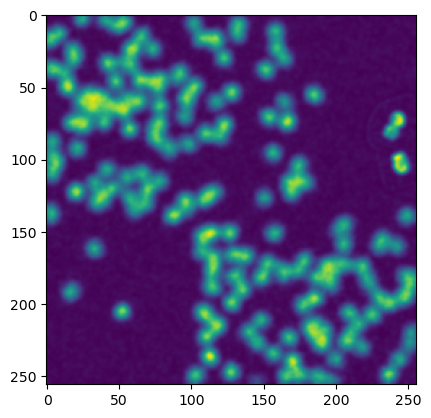

 25%|█████████████████████████████████████████████▊                                                                                                                                         | 1/4 [00:03<00:11,  3.99s/it]WARNING:basicpy.basicpy:Reweighting did not converge.


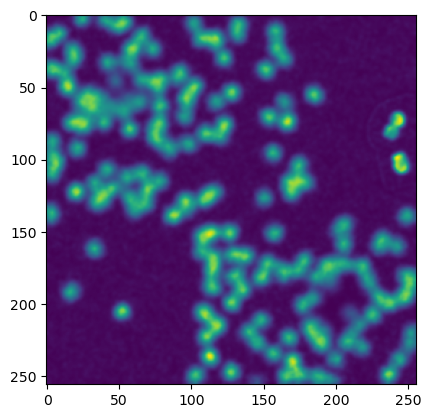

 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2/4 [00:07<00:07,  3.60s/it]

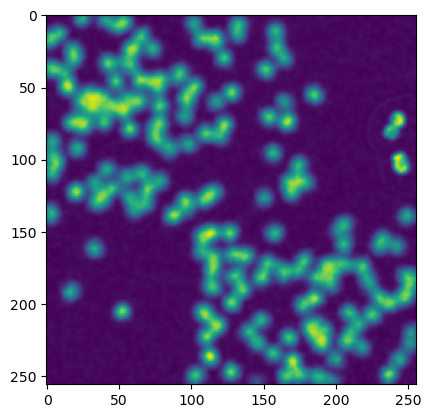

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3/4 [00:10<00:03,  3.20s/it]

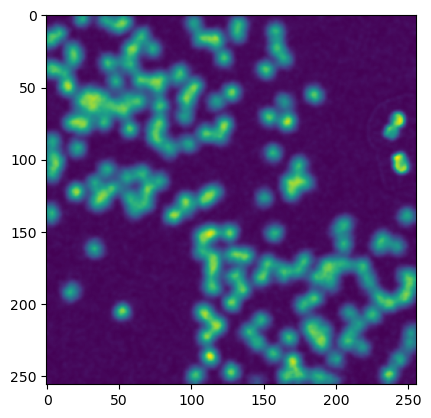

  0%|                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

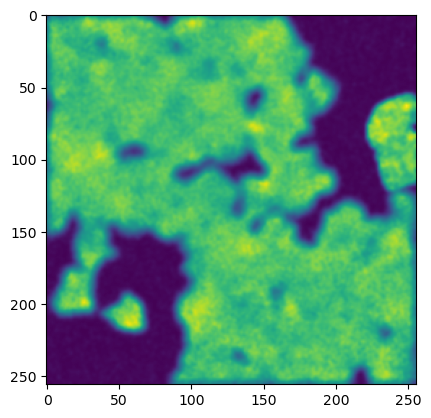

 25%|█████████████████████████████████████████████▊                                                                                                                                         | 1/4 [00:02<00:08,  2.86s/it]

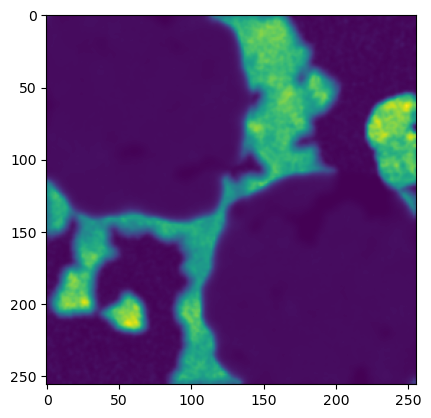

 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2/4 [00:05<00:05,  2.92s/it]

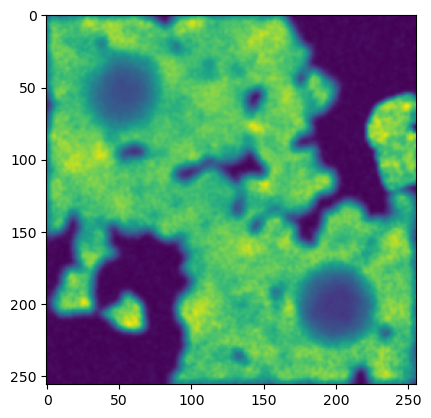

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3/4 [00:08<00:02,  2.81s/it]

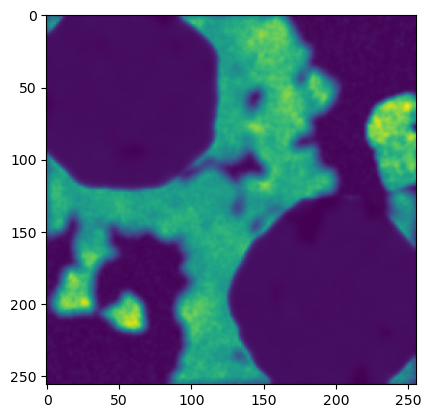

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.80s/it]


In [21]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
    )
)
conds = list(
    product(
        list(np.logspace(-3, 2, 15)),
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
        list(range(5)),
    )
)
parameters = []
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    for fitting_mode, sort_intensity, use_weight in tqdm(conds0):
        np.random.seed(1135 + channel_index * 50000)
        p = {
            "smoothness_flatfield": 0.05,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {
                "channel_index": channel_index,
                "use_weight": use_weight,
            }
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        b.fit(im, fitting_weight=w)
        transformed_image = b.transform(im, timelapse=True)
        plt.imshow(transformed_image[-1])
        plt.show()
        vmin, vmax = np.quantile(transformed_image, [histogram_qmin, histogram_qmax])
        entropy_vmin = vmin_factor * vmin
        val_range = (vmax - vmin * vmin_factor) * vrange_factor
        p2["val_range"] = val_range
        parameters.append(p2)

val_ranges_df = pd.DataFrame.from_records(parameters).set_index(
    ["channel_index", "fitting_mode", "sort_intensity", "use_weight"]
)
val_ranges_df.to_csv(path.join(file_path, f"wo_darkfield_val_ranges.csv"))

In [24]:
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    parameters = []
    flatfields = []
    baselines = []
    for smoothness_flatfield, fitting_mode, sort_intensity, use_weight, rep in tqdm(
        conds
    ):
        val_range = val_ranges_df.loc[
            (channel_index, fitting_mode, sort_intensity, use_weight), "val_range"
        ]
        np.random.seed(1135 + channel_index * 50000 + rep)
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        try:
            b.fit(im, fitting_weight=w)
            flatfields.append(b.flatfield)
            baselines.append(b.baseline)

            transformed_image = b.transform(im, timelapse=True)
            vmin, vmax = np.quantile(
                transformed_image, [histogram_qmin, histogram_qmax]
            )
            entropy_vmin = vmin_factor * vmin
            entropy_vmax = entropy_vmin + val_range
            p2["entropy"] = entropy(
                transformed_image,
                vmin=entropy_vmin,
                vmax=entropy_vmax,
                bins=histogram_bins,
                weights=w,
                clip=True,
            )
            p2["fourier_L0_norm"] = fourier_L0_norm(
                b.flatfield,
                fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius,
            )
            p2["autotune_cost"] = autotune_cost(
                transformed_image,
                b.flatfield,
                entropy_vmin=entropy_vmin,
                entropy_vmax=entropy_vmax,
                histogram_bins=histogram_bins,
                fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                fourier_l0_norm_threshold=fourier_l0_norm_threshold,
            )
        except RuntimeError:
            flatfields.append(np.ones_like(b.flatfield) * np.nan)
            baselines.append(np.ones_like(b.baseline) * np.nan)
            p2["autotune_cost"] = np.nan
        finally:
            parameters.append(p2)
    shape = [f.shape for f in flatfields][0]
    flatfields2 = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan for f in flatfields
    ]
    shape = baselines[0].shape
    baselines2 = [
        np.array(b)
        if hasattr(b, "shape") and b.shape == shape
        else np.ones(shape) * np.nan
        for b in baselines
    ]
    np.save(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        flatfields2,
    )
    np.save(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        baselines2,
    )
    assert len(flatfields2) == len(parameters)
    parameters_df = pd.DataFrame.from_records(parameters)
    parameters_df.to_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv")
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [32:24<00:00,  6.48s/it]


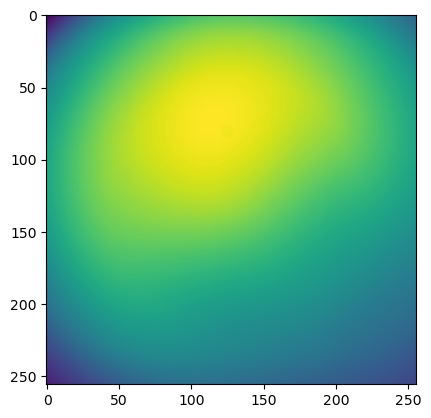

In [25]:
plt.imshow(flatfield_true)

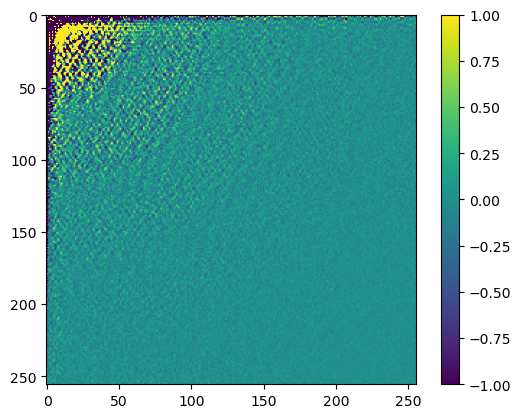

In [26]:
from scipy.fft import dctn

SF = dctn(flatfield_true)
plt.imshow(SF, vmin=-1, vmax=1)
plt.colorbar()

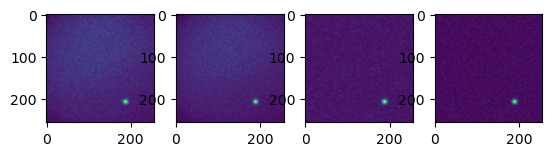

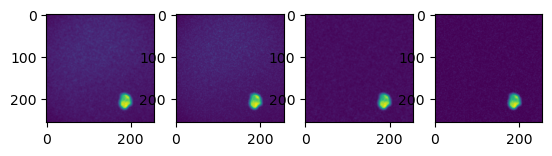

{2: {'entropy': 3.2081795083439935, 'fourier_L0_norm': 0.19904959814197964, 'autotune_cost': 1983.7041609281405}, 0: {'entropy': 4.014467156147514, 'fourier_L0_norm': 0.19904959814197964, 'autotune_cost': 1984.5104485759439}}


In [27]:
gt_values = {}

for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    im_orig = images_distorted_wo_darkfield[channel_index]
    im = add_noise(im_orig)
    plt.subplot(141)
    plt.imshow(im[0])
    plt.subplot(142)
    plt.imshow(im_orig[0])

    b.flatfield = flatfield_true
    b.baseline = baseline_true
    b.darkfield = np.zeros_like(flatfield_true)
    transformed_image = b.transform(im, timelapse=True)
    transformed_image2 = b.transform(im_orig, timelapse=True)
    vmin, vmax = np.quantile(transformed_image, [histogram_qmin, histogram_qmax])
    entropy_vmin = vmin_factor * vmin
    entropy_vmax = entropy_vmin + val_range

    v = {}
    v["entropy"] = float(
        entropy(
            transformed_image,
            vmin=entropy_vmin,
            vmax=entropy_vmax,
            bins=histogram_bins,
            weights=w,
            clip=True,
        )
    )
    v["fourier_L0_norm"] = float(
        fourier_L0_norm(
            b.flatfield,
            fourier_l0_norm_image_threshold,
            fourier_l0_norm_fourier_radius,
        )
    )
    v["autotune_cost"] = float(
        autotune_cost(
            transformed_image,
            b.flatfield,
            entropy_vmin=entropy_vmin,
            entropy_vmax=entropy_vmax,
            histogram_bins=histogram_bins,
            fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
            fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
            fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
            fourier_l0_norm_threshold=fourier_l0_norm_threshold,
        )
    )
    plt.subplot(143)
    plt.imshow(transformed_image[0])
    plt.subplot(144)
    plt.imshow(transformed_image2[0])
    plt.show()
    gt_values[channel_index] = v
print(gt_values)
with open("wo_darkfield_ground_truth_values.yaml", "w") as f:
    yaml.dump(gt_values, f)

In [28]:
parameters_df

,smoothness_flatfield,fitting_mode,sort_intensity,channel_index,use_weight,rep,entropy,fourier_L0_norm,autotune_cost
0,0.001,ladmap,False,0,True,0,2.610657,0.337286,3366.867915
1,0.001,ladmap,False,0,True,1,2.543228,0.338050,3374.509413
2,0.001,ladmap,False,0,True,2,2.539823,0.338157,3375.577058
3,0.001,ladmap,False,0,True,3,2.486991,0.336934,3363.354272
4,0.001,ladmap,False,0,True,4,2.571287,0.336675,3360.757288
...,...,...,...,...,...,...,...,...,...
295,100.000,approximate,False,0,False,0,4.452460,0.000000,4.452460
296,100.000,approximate,False,0,False,1,4.452352,0.000000,4.452352
297,100.000,approximate,False,0,False,2,4.452771,0.000000,4.452771
298,100.000,approximate,False,0,False,3,4.452945,0.000000,4.452945


In [ ]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [
            # True,
            False
        ],
        [True, False],
    )
)

conds = list(
    product(
        [
            nuc_channel_idx,
            cyto_channel_idx,
        ],
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(range(5)),
    )
)
"""
conds = list(
    product(
        [
            nuc_channel_idx,
            cyto_channel_idx,
        ],
        list(np.logspace(-3, 2, 1)),
        list(np.logspace(-3, 2, 1)),
        list(np.logspace(-3, 2, 1)),
        list(range(1)),
    )
)
"""

np.random.seed(1136)
for fitting_mode, sort_intensity, use_weight in conds0[-1:]:
    parameters_d = []
    flatfields_d = []
    darkfields_d = []
    baselines_d = []
    label = f"{fitting_mode}_sort{sort_intensity}_weight{use_weight}"
    for (
        channel_index,
        smoothness_flatfield,
        smoothness_darkfield,
        sparse_cost_darkfield,
        rep,
    ) in tqdm(conds):
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "smoothness_darkfield": smoothness_darkfield,
            "sparse_cost_darkfield": sparse_cost_darkfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        im = images_distorted_w_darkfield[channel_index]
        im = add_noise(im)
        b = BaSiC(**p, get_darkfield=True)
        try:
            b.fit(im, fitting_weight=weights[channel_index] if use_weight else None)
            transformed_image = b.transform(im, timelapse=True)
            vmin, vmax = np.quantile(
                transformed_image, [histogram_qmin, histogram_qmax]
            )
            entropy_vmin = vmin_factor * vmin
            entropy_vmax = entropy_vmin + val_range
            p2["entropy"] = entropy(
                transformed_image,
                vmin=entropy_vmin,
                vmax=entropy_vmax,
                bins=histogram_bins,
                weights=w,
                clip=True,
            )
            p2["fourier_L0_norm"] = fourier_L0_norm(
                b.flatfield,
                fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius,
            )
            p2["autotune_cost"] = autotune_cost(
                transformed_image,
                b.flatfield,
                entropy_vmin=entropy_vmin,
                entropy_vmax=entropy_vmax,
                histogram_bins=histogram_bins,
                fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                fourier_l0_norm_threshold=fourier_l0_norm_threshold,
            )

            flatfields_d.append(b.flatfield)
            darkfields_d.append(b.darkfield)
            baselines_d.append(b.baseline)
        except (RuntimeError, AssertionError):
            flatfields_d.append(np.ones_like(b.flatfield) * np.nan)
            darkfields_d.append(np.ones_like(b.darkfield) * np.nan)
            baselines_d.append(np.ones_like(b.baseline) * np.nan)
        parameters_d.append(p2)

    shape = [f.shape for f in flatfields][0]
    flatfields2_d = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan
        for f in flatfields_d
    ]
    darkfields2_d = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan
        for f in darkfields_d
    ]
    shape = baselines[0].shape
    baselines2_d = [
        np.array(b)
        if hasattr(b, "shape") and b.shape == shape
        else np.ones(shape) * np.nan
        for b in baselines_d
    ]

    np.save(path.join(file_path, f"w_darkfield_flatfields_{label}.npy"), flatfields2_d)
    np.save(path.join(file_path, f"w_darkfield_darkfields_{label}.npy"), darkfields2_d)
    np.save(path.join(file_path, f"w_darkfield_baselines_{label}.npy"), baselines2_d)
    parameters_df = pd.DataFrame.from_records(parameters_d)
    parameters_df.to_csv(path.join(file_path, f"w_darkfield_parameters_{label}.csv"))

  0%|                                                                                                                                                                                             | 0/640 [00:00<?, ?it/s]

In [30]:
parameters_df

,smoothness_flatfield,smoothness_darkfield,sparse_cost_darkfield,fitting_mode,sort_intensity,channel_index,use_weight,rep,entropy,fourier_L0_norm,autotune_cost
0,0.001,0.001,0.001,approximate,False,2,False,0,3.367405,0.366409,3657.456883
1,0.001,0.001,0.001,approximate,False,2,False,1,3.365861,0.366516,3658.524924
2,0.001,0.001,0.001,approximate,False,2,False,2,3.354549,0.366974,3663.097543
3,0.001,0.001,0.001,approximate,False,2,False,3,3.365076,0.368930,3682.666179
4,0.001,0.001,0.001,approximate,False,2,False,4,3.391931,0.367020,3663.593318
...,...,...,...,...,...,...,...,...,...,...,...
635,100.000,100.000,100.000,approximate,False,0,False,0,4.534973,0.000000,4.534973
636,100.000,100.000,100.000,approximate,False,0,False,1,4.535199,0.000000,4.535199
637,100.000,100.000,100.000,approximate,False,0,False,2,4.535040,0.000000,4.535040
638,100.000,100.000,100.000,approximate,False,0,False,3,4.534585,0.000000,4.534585
